In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder, PolynomialFeatures
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor, StackingRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from sklearn.linear_model import Ridge
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.decomposition import PCA
from hyperopt import fmin, tpe, hp, Trials

# Load the dataset
df = pd.read_csv("Combined_Sales_Data.csv")

df.fillna(0, inplace=True)

df['Date'] = pd.to_datetime(df['Date'])
df['Month'] = df['Date'].dt.month
df['Year'] = df['Date'].dt.year
df['Quarter'] = df['Date'].dt.quarter
df['Day_of_Week'] = df['Date'].dt.dayofweek
df['Week_of_Year'] = df['Date'].dt.isocalendar().week

df['Scheme_Impact'] = df['Scheme Activity'] * df['Scheme Type']

# Lag Features
df['Prev_Month_Sales'] = df['Sales'].shift(1).fillna(df['Sales'].median())
df['Rolling_Avg_Sales_3M'] = df['Sales'].rolling(window=3, min_periods=1).mean()
df['Rolling_Avg_Sales_6M'] = df['Sales'].rolling(window=6, min_periods=1).mean()

# Apply log transformation to stabilize variance
df['Sales'] = np.log1p(df['Sales'])

# Seasonal decomposition
result = seasonal_decompose(df['Sales'], model='additive', period=12)
df['Seasonal'] = result.seasonal

df.dropna(inplace=True)

categorical_features = ['Locations', 'C&F Agent', 'Division', 'SKU']
numerical_features = ['Month', 'Year', 'Quarter', 'Day_of_Week', 'Week_of_Year', 'OpeningStock', 'SellingPrice', 'Scheme Activity', 'Scheme Type', 'Scheme_Impact', 'Prev_Month_Sales', 'Rolling_Avg_Sales_3M', 'Rolling_Avg_Sales_6M', 'Seasonal']

ohe = OneHotEncoder(handle_unknown='ignore')
scaler = StandardScaler()
pca = PCA(n_components=10)
poly = PolynomialFeatures(degree=2, interaction_only=True, include_bias=False)

preprocessor = ColumnTransformer([
    ('num', Pipeline([('scaler', scaler), ('poly', poly), ('pca', pca)]), numerical_features),
    ('cat', ohe, categorical_features)
])

X = df[numerical_features + categorical_features]
y = df['Sales']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

xgb = XGBRegressor(n_estimators=700, learning_rate=0.03, max_depth=8, random_state=42)
rf = RandomForestRegressor(n_estimators=700, max_depth=12, random_state=42)
lgb = LGBMRegressor(n_estimators=700, learning_rate=0.03, max_depth=8, random_state=42)

stacked_model = StackingRegressor(
    estimators=[('XGB', xgb), ('RF', rf), ('LGB', lgb)],
    final_estimator=Ridge(alpha=1.0)
)

pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('model', stacked_model)
])

# Train the model
pipeline.fit(X_train, y_train)

y_pred = np.expm1(pipeline.predict(X_test))
y_test = np.expm1(y_test)

r2 = r2_score(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

print(f'R² Score: {r2:.4f}')
print(f'Mean Absolute Error: {mae:.2f}')
print(f'Root Mean Squared Error: {rmse:.2f}')

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000316 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2644
[LightGBM] [Info] Number of data points in the train set: 6716, number of used features: 57
[LightGBM] [Info] Start training from score 9.663190
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, 

In [11]:
# Convert 'Date' to datetime
df1=pd.read_csv("Combined_Sales_Data.csv")
new_data = df1
new_data['Date'] = pd.to_datetime(new_data['Date'])

# Create derived features
new_data['Month'] = new_data['Date'].dt.month
new_data['Year'] = new_data['Date'].dt.year
new_data['Quarter'] = new_data['Date'].dt.quarter
new_data['Day_of_Week'] = new_data['Date'].dt.dayofweek
new_data['Week_of_Year'] = new_data['Date'].dt.isocalendar().week

# Create 'Scheme_Impact'
new_data['Scheme_Impact'] = new_data['Scheme Activity'] * new_data['Scheme Type']

# Create lag features
new_data['Prev_Month_Sales'] = new_data['Sales'].shift(1).fillna(new_data['Sales'].median())
new_data['Rolling_Avg_Sales_3M'] = new_data['Sales'].rolling(window=3, min_periods=1).mean()
new_data['Rolling_Avg_Sales_6M'] = new_data['Sales'].rolling(window=6, min_periods=1).mean()

# Apply log transformation to 'Sales'
new_data['Sales'] = np.log1p(new_data['Sales'])

# Seasonal decomposition (assuming the same period as before)
result_new = seasonal_decompose(new_data['Sales'], model='additive', period=12)
new_data['Seasonal'] = result_new.seasonal

# Drop rows with NaN values (if any)
new_data.dropna(inplace=True)

In [12]:
# Select the features
X_new = new_data[numerical_features + categorical_features]

# Preprocess the data
X_new_preprocessed = preprocessor.transform(X_new)

In [13]:
# Make predictions
y_pred_new = pipeline.predict(X_new)

In [14]:
# Reverse the log transformation
y_pred_new_original = np.expm1(y_pred_new)

In [15]:
# Add predictions to the DataFrame
new_data['Predicted_Sales'] = y_pred_new_original

# Display the DataFrame with predictions
print(new_data[['Date', 'Locations', 'C&F Agent', 'Division', 'SKU', 'Predicted_Sales']])

           Date         Locations          C&F Agent Division     SKU  \
0    2004-01-01  AHMEDABAD BRANCH  AHMEDABAD AGENT 2    CPMNT  PROD E   
1    2004-02-01  AHMEDABAD BRANCH  AHMEDABAD AGENT 2    CPMNT  PROD E   
2    2004-03-01  AHMEDABAD BRANCH  AHMEDABAD AGENT 2    CPMNT  PROD E   
3    2004-04-01  AHMEDABAD BRANCH  AHMEDABAD AGENT 2    CPMNT  PROD E   
4    2004-05-01  AHMEDABAD BRANCH  AHMEDABAD AGENT 2    CPMNT  PROD E   
...         ...               ...                ...      ...     ...   
8391 2006-08-01   ZIRAKPUR BRANCH   ZIRAKPUR AGENT 1    CPASF  PROD C   
8392 2006-09-01   ZIRAKPUR BRANCH   ZIRAKPUR AGENT 1    CPASF  PROD C   
8393 2006-10-01   ZIRAKPUR BRANCH   ZIRAKPUR AGENT 1    CPASF  PROD C   
8394 2006-11-01   ZIRAKPUR BRANCH   ZIRAKPUR AGENT 1    CPASF  PROD C   
8395 2006-12-01   ZIRAKPUR BRANCH   ZIRAKPUR AGENT 1    CPASF  PROD C   

      Predicted_Sales  
0        93890.322703  
1        49358.938645  
2        44596.288421  
3        85579.264296  
4  

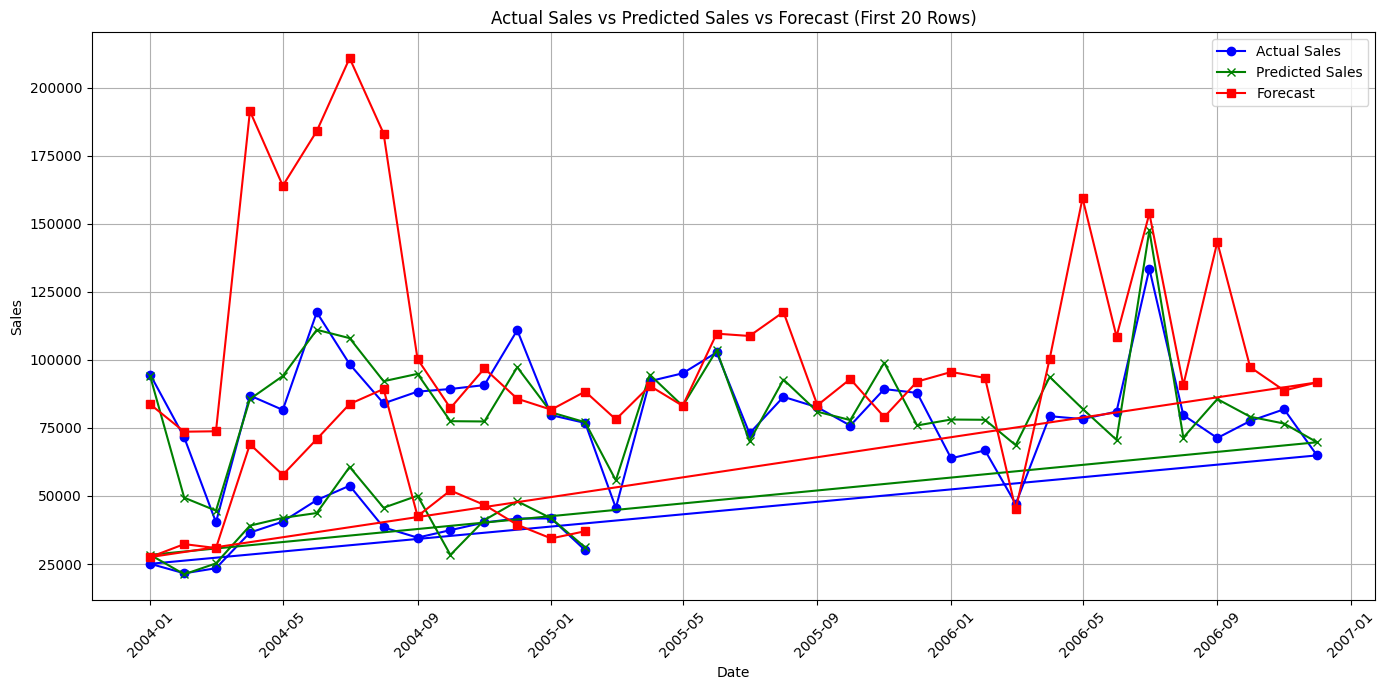

In [ ]:
import matplotlib.pyplot as plt

# Select the first 20 rows
new_data_first_20 = new_data.head(30).copy()

# Ensure the 'Date' column is in datetime format
new_data_first_20['Date'] = pd.to_datetime(new_data_first_20['Date'])

# Reverse the log transformation for 'Sales' to get actual sales values
new_data_first_20['Actual_Sales'] = np.expm1(new_data_first_20['Sales'])

# Preprocess the data
X_new_first_20 = new_data_first_20[numerical_features + categorical_features]
X_new_preprocessed_first_20 = preprocessor.transform(X_new_first_20)

# Make predictions
y_pred_new_first_20 = pipeline.predict(X_new_first_20)

# Reverse the log transformation for predictions
new_data_first_20['Predicted_Sales'] = np.expm1(y_pred_new_first_20)

# Plot the data
plt.figure(figsize=(14, 7))

# Plot Actual Sales
plt.plot(new_data_first_20['Date'], new_data_first_20['Actual_Sales'], label='Actual Sales', color='blue', marker='o')

# Plot Predicted Sales
plt.plot(new_data_first_20['Date'], new_data_first_20['Predicted_Sales'], label='Predicted Sales', color='green', marker='x')

# Plot Forecast Values
plt.plot(new_data_first_20['Date'], new_data_first_20['Forecast'], label='Forecast', color='red', marker='s')

# Add labels, title, and legend
plt.xlabel('Date')
plt.ylabel('Sales')
plt.title('Actual Sales vs Predicted Sales vs Forecast (First 20 Rows)')
plt.legend()
plt.grid(True)

# Rotate x-axis labels for better readability
plt.xticks(rotation=45)

# Show the plot
plt.tight_layout()
plt.show()